In [47]:
import numpy as np
from matplotlib import pyplot as plt
from src.FireFramework import * # importieren des Frameworks
from PIL import Image

### Hilfsfunktionen

In [48]:
def drawImage(field, index):
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (100,100))], axis = 2))
    plt.show()

In [49]:
def loadImage(path, size):
    img_ = Image.open(path).resize(size, Image.BICUBIC)
    img = np.array(img_) / 255
    img_.close()
    return img

In [50]:
def dot(t1,t2):
    return t1[0] * t2[0] + t1[1] * t2[1]

### Daten definieren

In [51]:
# Liste der pro Zelle zu speichernden Werte
params = ["fuel", "fire", "windx", "windy", "height"]

# Relativvektoren der zu betrachtenen Nachbarn (Kreis mit Radius 5)
radius = 2

relative_neighbours = []
for x in range(radius * 2 +1):
    for y in range(radius*2 +1):
        xcord = x - radius
        ycord = y - radius
        r = xcord**2 + ycord**2
        
        if r <= radius**2 and r != 0:
            relative_neighbours.append((xcord,ycord))

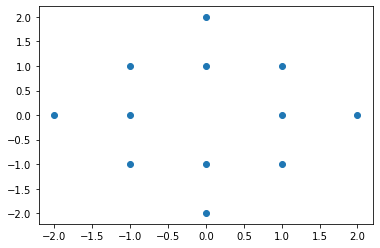

In [52]:
nns = np.array(relative_neighbours)
plt.scatter(nns[:,0],nns[:,1])

In [53]:
fuelmap = loadImage("data/fuelmap1.jpg", (100,100))
heightmap = loadImage("data/heightmap.jpg", (100,100))

def initial_field(row, col):
    fuel = (1 - fuelmap[row,col,2])**4
    burn = 0
    if row == 20 and col == 20: burn = 1
    
    height = heightmap[row,col,0]
    windx = 1
    windy = 0
    
    return [fuel, burn, windx, windy, height] # Hier der Anfangswert-return

### Modell definieren

In [54]:
def transition(cellState, neighbourStates, returnState):
    
    #Parameter der Nachbarn:
    slope = []
    rel_wind = []
    neighbour_fire = []
    distance = []
    
    #Vorbereitung der Werte der Nachbarn
    for n in neighbourStates:
        
        slope_ = np.tanh(n.getParam("height") - cellState.getParam("height"))
        fire_ = n.getParam("fire")
        distance_ = np.sqrt(dot(n.getRelativeVector(), n.getRelativeVector()))
        wind = (n.getParam("windx"), n.getParam("windy"))
        rel_wind_ = np.tanh(dot(wind, n.getRelativeVector()) / distance_)
        
        slope.append(slope_)
        neighbour_fire.append(fire_)
        distance.append(distance_)
        rel_wind.append(rel_wind_)

    #Konvertieren zu numpy arrays
    slope = np.array(slope)
    rel_wind = np.array(rel_wind)
    neighbour_fire = np.array(neighbour_fire)
    distance = np.array(distance)

    #Wahrscheinlichkeiten berechnen

    slope_coeff = - np.sum(neighbour_fire * slope / distance)
    wind_coeff = - np.sum(neighbour_fire * rel_wind / distance)
    
    p_burn = 1/8 * np.sum(neighbour_fire / distance) + 0.05 * slope_coeff + 0.1 * wind_coeff
    p_burn *= cellState.getParam("fuel")
    
    p_stop = (1 - cellState.getParam("fuel")) ** 8  #Erlöschen bei wenig Brennwert
    
    #Wahrscheinlichkeiten umsetzen
    
    if p_burn >= np.random.uniform():
        returnState.setParam("fire", 1)
        
    if p_stop >= np.random.uniform():
        returnState.setParam("fire", 0)
        
    returnState.addToParam("fuel", -0.05*cellState.getParam("fire")) # Verringerung des Brennwerts
    if returnState.getParam("fuel") < 0:
        returnState.setParam("fuel", 0)

In [55]:
# Hier wird das Gitter erzeugt und die oben definierten Parameter übergeben..
g = Grid(100, 100, params, relative_neighbours, transition, initial_field)

### Modell auswerten

In [56]:
# Läuft mehrere Iterationen durch und gibt das ganze Feld (mit zeitlicher Entwicklung) zurück.
result = g.runModel(50)

2%
12%
22%
32%
42%
52%
62%
72%
82%
92%


In [57]:
def drawFrame(field, index):
    plt.figure()
    plt.imshow(np.stack([field[index,:,:,1],field[index,:,:,0],np.zeros(shape = (100,100))], axis = 2))
    #plt.savefig("frames/frame"+str(i)+".png")
    plt.show()

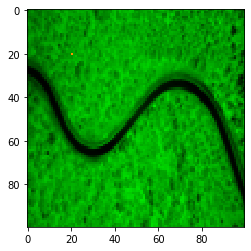

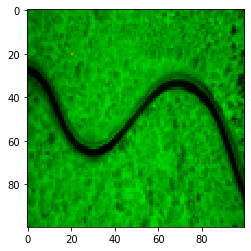

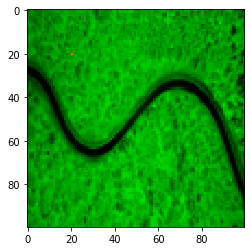

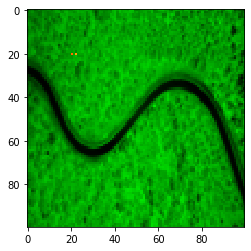

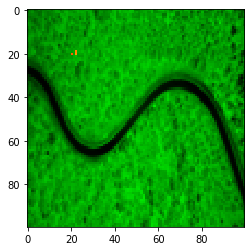

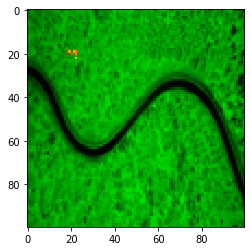

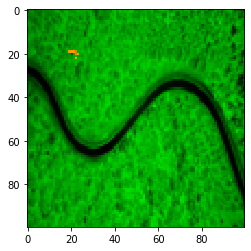

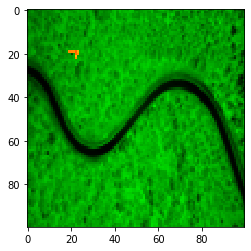

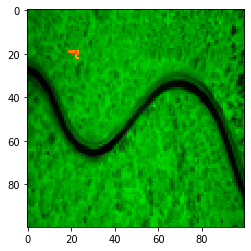

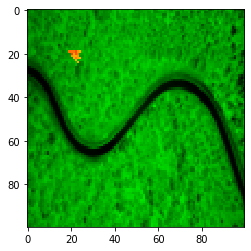

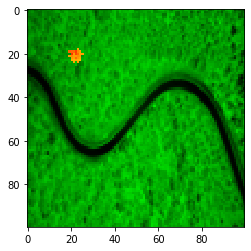

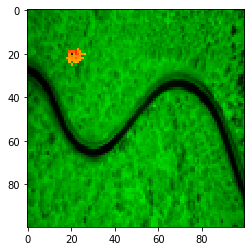

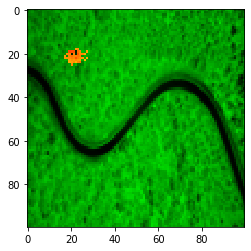

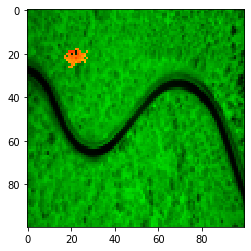

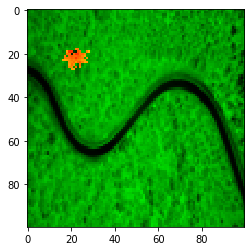

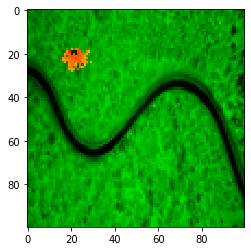

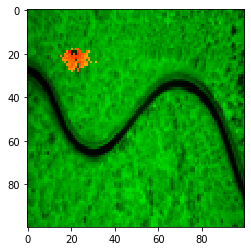

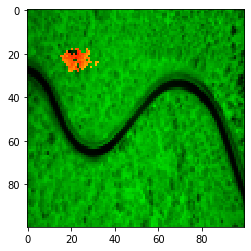

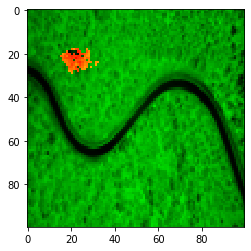

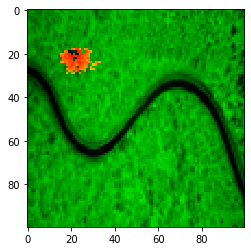

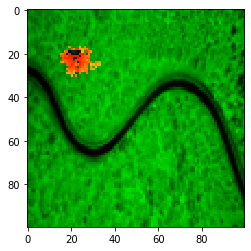

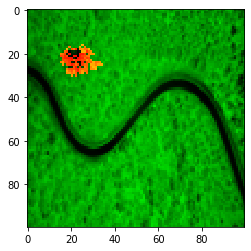

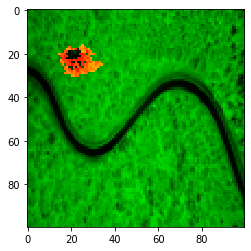

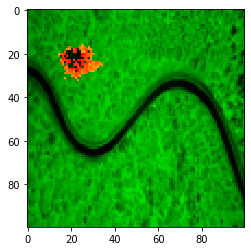

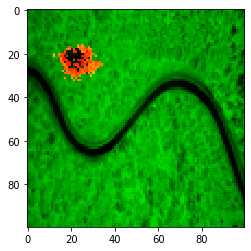

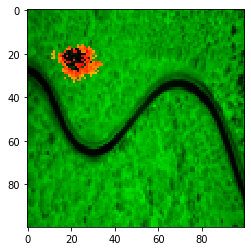

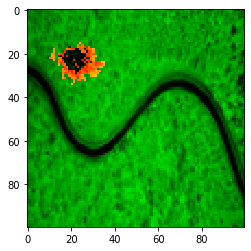

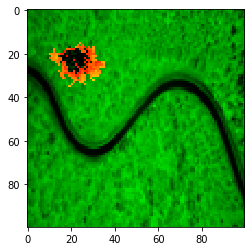

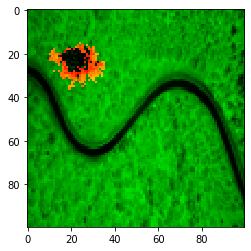

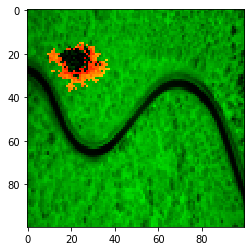

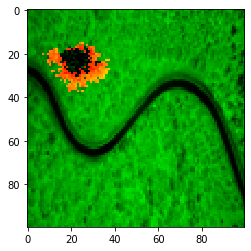

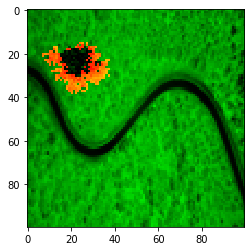

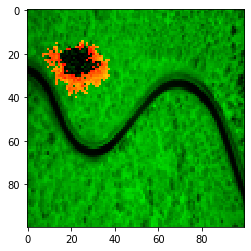

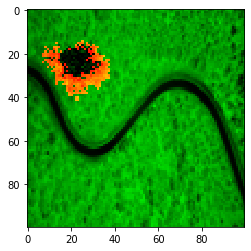

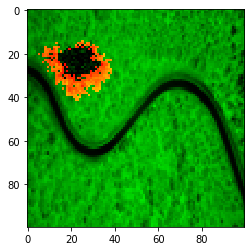

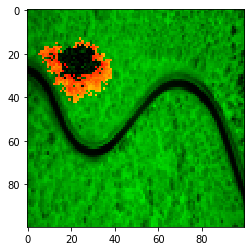

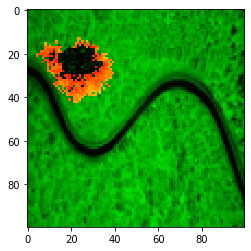

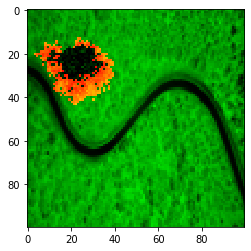

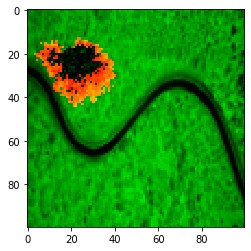

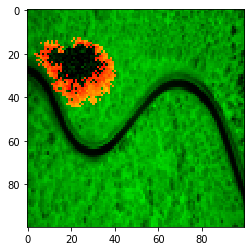

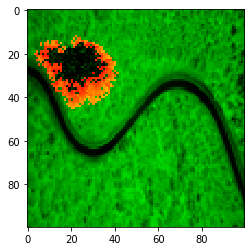

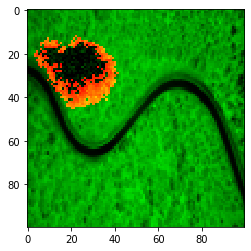

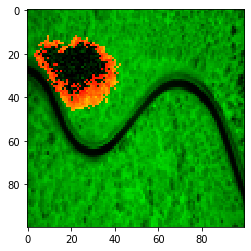

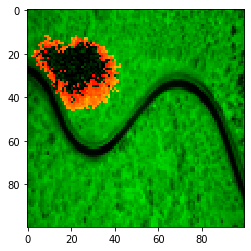

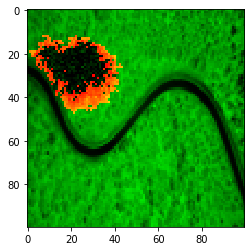

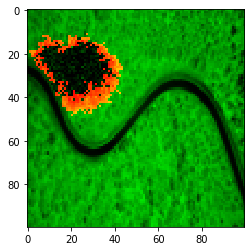

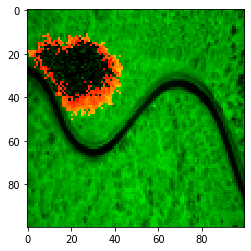

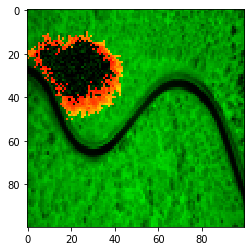

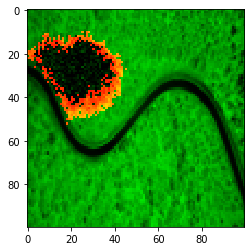

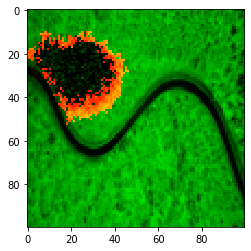

In [58]:
for i in range(50):
    drawFrame(result, i)